# Daten Analyse
Dieses Notebook dient der Datennanalyse. Aus verschiedenen Fassungen des RTzW'95 werden Wörter gezählt. 
---

In [11]:
import pandas as pd
import numpy as np
import matplotlib as plt
from collections import Counter
from wordcloud import WordCloud

In [12]:
# read data from csv
df = pd.read_csv("RKG_dataframe.csv", sep='|', encoding='utf-8')

<Axes: title={'center': 'Anzahl der Wörter pro Artikel und Fassung'}, xlabel='Artikel'>

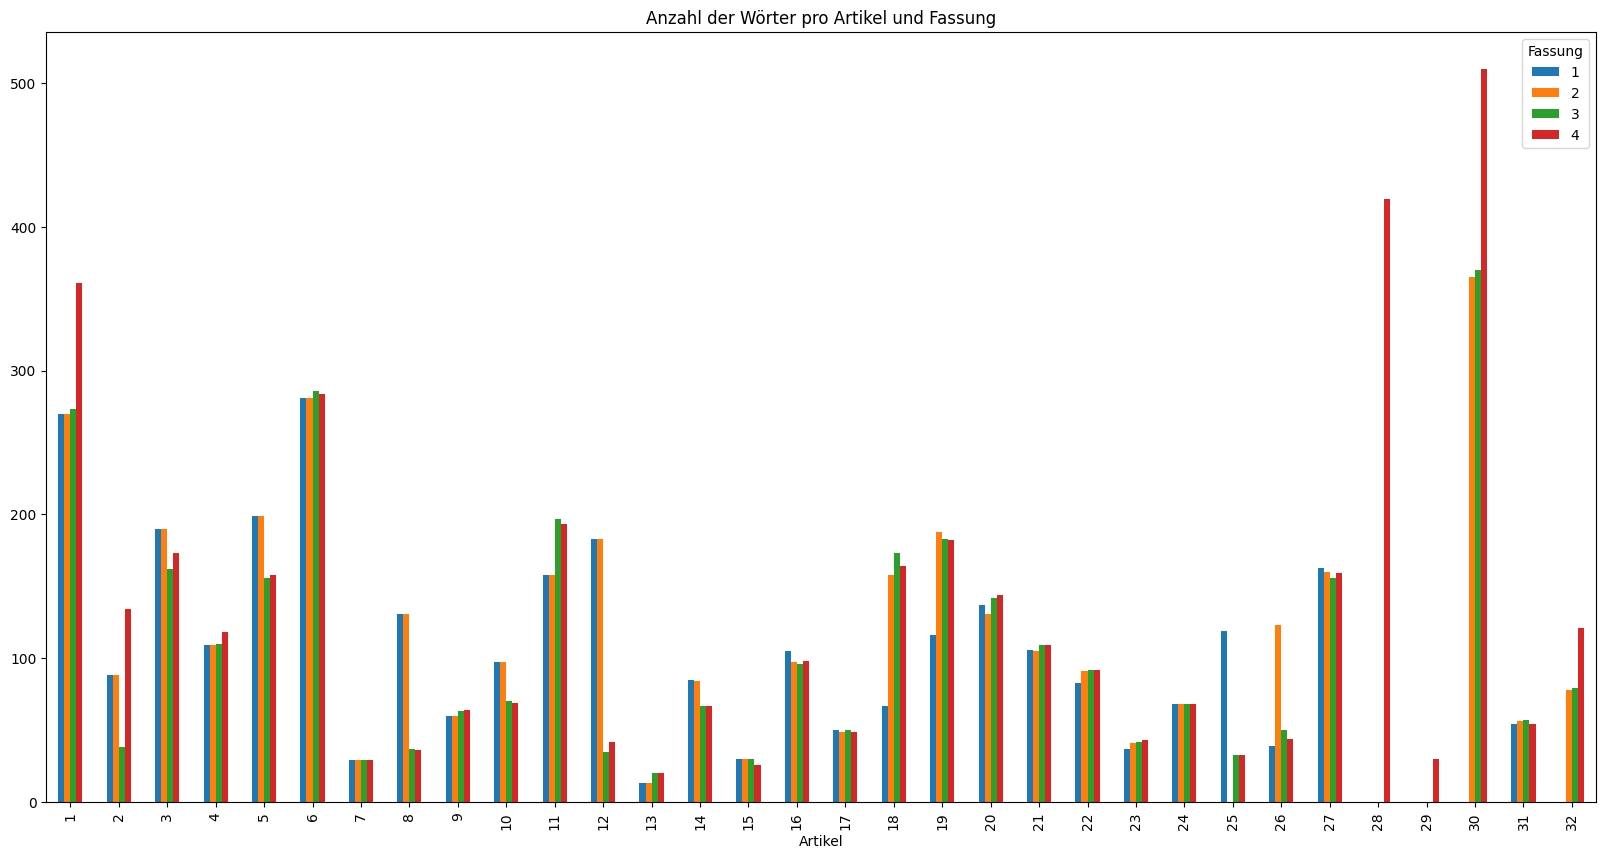

In [13]:
# build histplot
woerter_df = df.groupby(["Artikel", "Fassung"])["Anzahl_Woerter"].max().unstack()
woerter_df.plot(kind='bar', figsize=(20,10), title="Anzahl der Wörter pro Artikel und Fassung")

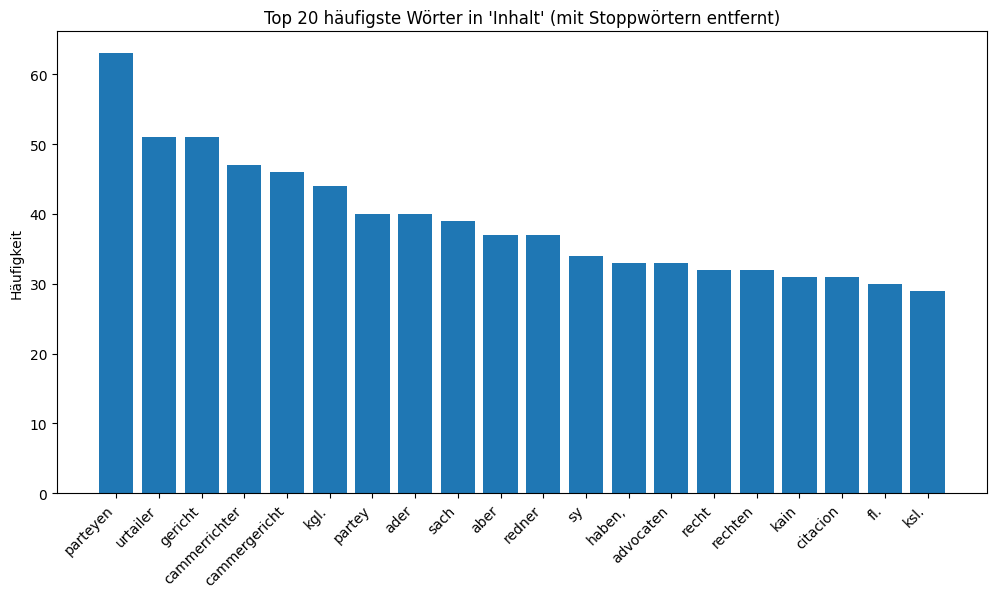

In [35]:
from collections import Counter
import matplotlib.pyplot as plt

# Sicherstellen, dass die Spalte Inhalt als Text vorliegt
df["Inhalt"] = df["Inhalt"].astype(str)

# --- Stopwörter (kurze deutsche Liste; optional NLTK benutzen) ---
german_stopwords = {
    "alle", "allem", "allen", "aller", "alles", 
    "als", "also", "am", "an", "ander", "andere", "anderem", "anderen", 
    "auch", "auf", "aus", 
    "bei", "bis", 
    "dann", "das", "des", "dass", "dem", "den", "der", "die", "doch", "durch", "du", 
    "ein", "eine", "er", "es", 
    "fur", 
    "hat", "hatte", 
    "ich", "im", "in", "ir", "ist", "item", "Item", 
    "man", "mehr", "mit", "nach", "noch", "nit", "nicht", "nur", 
    "ob", "oder", "on", 
    "sachen", "sein", "sie", "sich", "sol", "soll", "sollen", "so", 
    "und", "über", 
    "vor", "von",
    "was", "wenn", "werden", "werden,", "wie", "wir", 
    "zum", "zur", "zu"
}


# Alle Wörter sammeln und Stoppwörter entfernen
all_words = " ".join(df["Inhalt"].tolist()).split()
filtered_words = [w.lower() for w in all_words if w.lower() not in german_stopwords]

# Häufigkeiten zählen
word_freq = Counter(filtered_words)

# ---- Balkendiagramm der Top 20 Wörter ----
top_words = word_freq.most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 häufigste Wörter in 'Inhalt' (mit Stoppwörtern entfernt)")
plt.ylabel("Häufigkeit")
plt.show()
